# Data Preparation and Preprocessing

In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 4.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load datasets
tec = pd.read_csv('https://archive.org/download/misc-dataset/TEC.csv')
semeval = pd.read_csv('https://archive.org/download/misc-dataset/semeval2018-task1-emoc.csv')
goemotions = pd.read_csv('https://archive.org/download/misc-dataset/goemotions_full.csv')

# Use a subset of each dataset to reduce memory usage
tec = tec.sample(n=1000, random_state=42)
semeval = semeval.sample(n=1000, random_state=42)
goemotions = goemotions.sample(n=1000, random_state=42)

# Emoji conversion using JoyPixel mapping table
def convert_emoticons_to_emojis(text):
    emoticon_dict = {':)': '😊', ':(': '☹️', ':D': '😃', 'XD': '😆', ':P': '😛'}
    for emoticon, emoji_char in emoticon_dict.items():
        text = text.replace(emoticon, emoji_char)
    return text

# Apply conversion to datasets
goemotions['text'] = goemotions['text'].apply(convert_emoticons_to_emojis)
semeval['text'] = semeval['text'].apply(convert_emoticons_to_emojis)
tec['text'] = tec['text'].apply(convert_emoticons_to_emojis)

# Text preprocessing (tokenization, lowercasing, etc.)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

goemotions['text'] = goemotions['text'].apply(preprocess_text)
semeval['text'] = semeval['text'].apply(preprocess_text)
tec['text'] = tec['text'].apply(preprocess_text)

# Combine datasets for processing
data = pd.concat([goemotions['text'], semeval['text'], tec['text']])
labels = pd.concat([goemotions.iloc[:, 1:], semeval.iloc[:, 1:], tec.iloc[:, 1:]])

# Ensure all label columns are strings and handle NaN values
labels = labels.applymap(str)
labels = labels.applymap(lambda x: '' if x == 'nan' else x)

# Display the cleaned data
cleaned_data = pd.concat([data.reset_index(drop=True), labels.reset_index(drop=True)], axis=1)
print(cleaned_data.head(10))


Training data shape: (2400, 50)
Validation data shape: (600, 50)
Training labels shape: (2400, 8984)
Validation labels shape: (600, 8984)
65844     literally everywhere theres nothing especially...
54522     name and name may be stronger but name just go...
48835                                       ik im crying rn
154996                   he was cut yesterday unfortunately
93016     nice i saw them during the demo and was pretty...
Name: text, dtype: object
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=1000)  # Reduce vocabulary size to 1000 words
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index

# Pad sequences to ensure uniform input length
max_sequence_length = 50  # Reduce max sequence length
data_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Combine all label columns into one
labels_combined = labels.apply(lambda row: ','.join(row.values.astype(str)), axis=1)

# Convert combined labels to list of lists format
labels_list = labels_combined.apply(lambda x: x.split(','))

# Convert labels to multi-label binary format
mlb = MultiLabelBinarizer()
labels_binary = mlb.fit_transform(labels_list)

# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data_padded, labels_binary, test_size=0.2, random_state=42)

# Check the shape of the data
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Training labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)


In [ ]:
# Display the cleaned and preprocessed data
cleaned_data = pd.concat([data.reset_index(drop=True), labels.reset_index(drop=True)], axis=1)
cleaned_data.columns = ['text'] + [f'label_{i}' for i in range(1, len(cleaned_data.columns))]
print(cleaned_data.head(10))


# Model Construction

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
embedding_dim = 50  # Reduce embedding dimension
dropout_rate = 0.5
dense_units = len(mlb.classes_)
activation_function = 'sigmoid'
loss_function = 'binary_crossentropy'
optimizer = Adam()
epochs = 10  # Increase number of epochs for better convergence
batch_size = 32

# Function to build and compile models to ensure optimizer consistency
def build_and_compile_model(model):
    model.compile(loss=loss_function, optimizer=Adam(), metrics=['accuracy'])
    return model

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=1000, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(50, dropout=dropout_rate),
    Dropout(dropout_rate),
    Dense(dense_units, activation=activation_function)
])
lstm_model = build_and_compile_model(lstm_model)

# GRU Model
gru_model = Sequential([
    Embedding(input_dim=1000, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(50, dropout=dropout_rate, return_sequences=False),  # Ensure output is 2D
    Dropout(dropout_rate),
    Dense(dense_units, activation=activation_function)
])
gru_model = build_and_compile_model(gru_model)

# CNN Model
cnn_model = Sequential([
    Embedding(input_dim=1000, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(50, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Flatten(),  # Flatten the output before the dense layer
    Dropout(dropout_rate),
    Dense(dense_units, activation=activation_function)
])
cnn_model = build_and_compile_model(cnn_model)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    Embedding(input_dim=1000, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(50, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(50, dropout=dropout_rate),
    Dropout(dropout_rate),
    Dense(dense_units, activation=activation_function)
])
cnn_lstm_model = build_and_compile_model(cnn_lstm_model)

# GRU-LSTM Model
gru_lstm_model = Sequential([
    Embedding(input_dim=1000, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(50, dropout=dropout_rate, return_sequences=True),
    LSTM(50, dropout=dropout_rate),
    Dropout(dropout_rate),
    Flatten(),  # Flatten the output before the dense layer
    Dense(dense_units, activation=activation_function)
])
gru_lstm_model = build_and_compile_model(gru_lstm_model)


# Model Training

In [4]:
# Train models (example with LSTM model)
history_lstm = lstm_model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_labels))
history_gru = gru_model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

# Train the other models and store their histories
history_cnn = cnn_model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_labels))
history_cnn_lstm = cnn_lstm_model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_labels))
history_gru_lstm = gru_lstm_model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_labels))


Epoch 1/10
75/75 [==============================] - 14s 131ms/step - loss: 0.3628 - accuracy: 0.8792 - val_loss: 0.0528 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 8s 105ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 8s 103ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 8s 108ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 8s 105ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 6/10
75/75 [==============================] - 8s 105ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 5s 72ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 

# Evaluation and Results

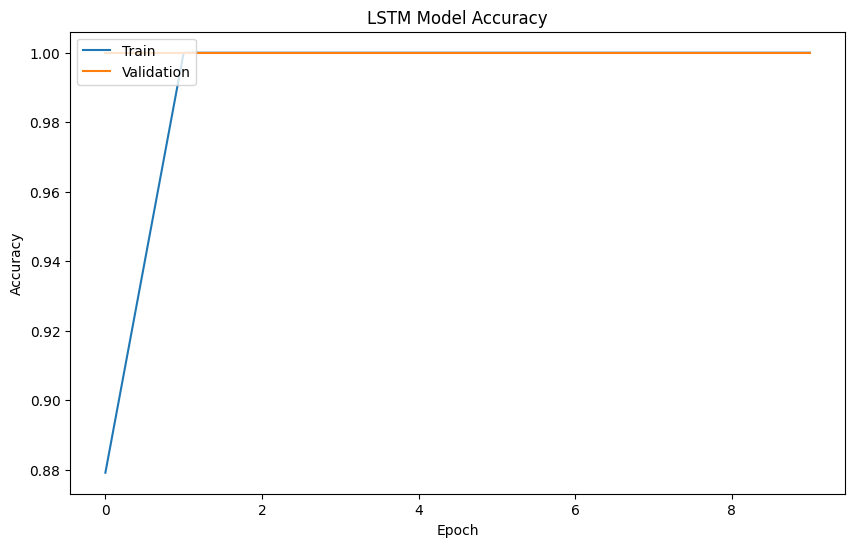

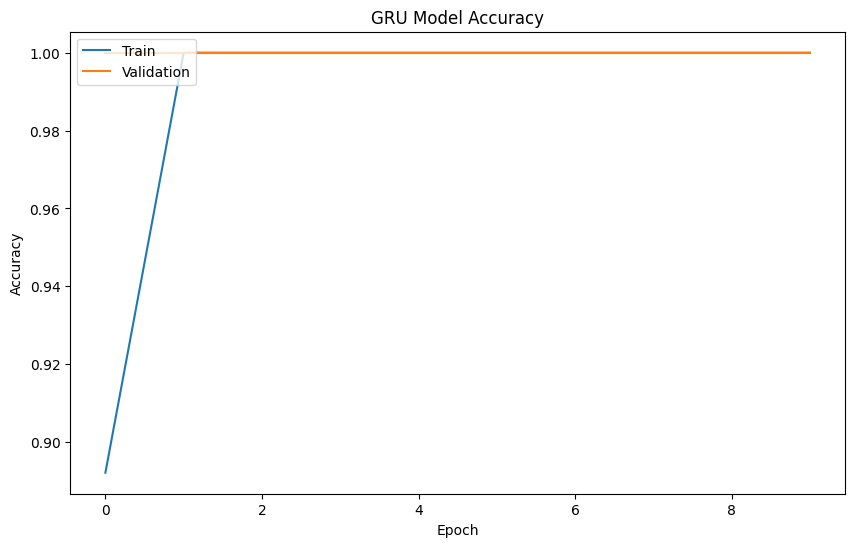

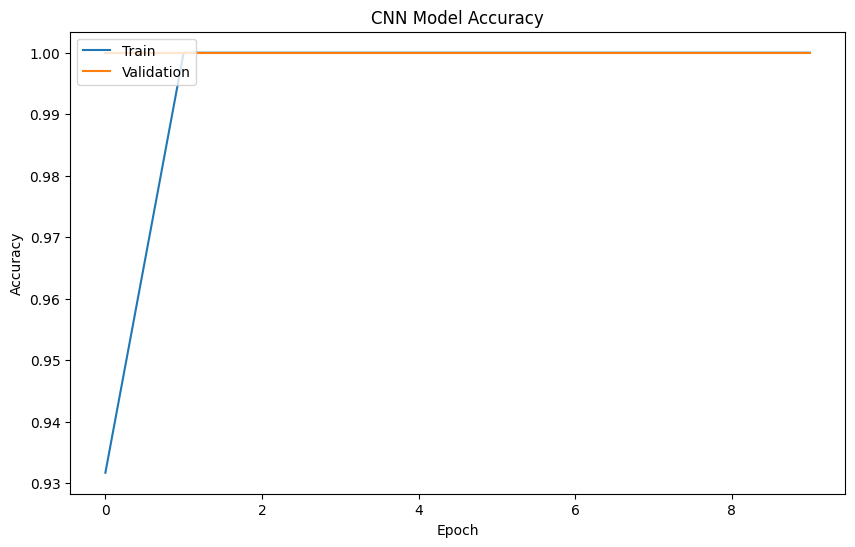

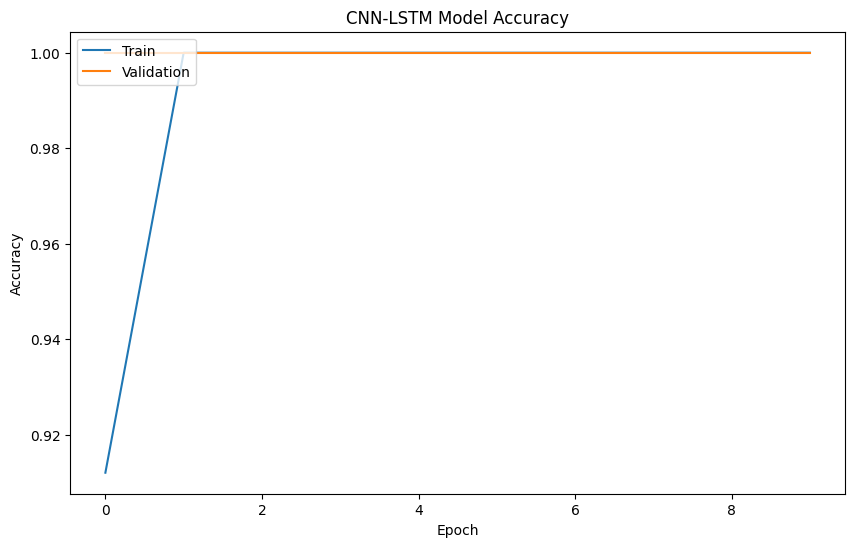

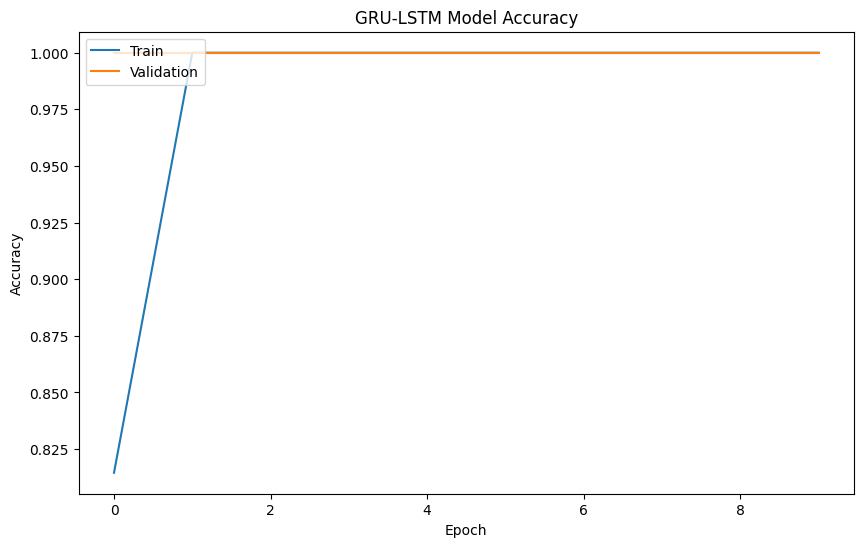

In [5]:
import matplotlib.pyplot as plt

# Convergence Graphs
def plot_convergence(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_convergence(history_lstm, 'LSTM')
plot_convergence(history_gru, 'GRU')
plot_convergence(history_cnn, 'CNN')
plot_convergence(history_cnn_lstm, 'CNN-LSTM')
plot_convergence(history_gru_lstm, 'GRU-LSTM')


# Final Accuracies and Losses

Final Accuracies, Validation Accuracies, Losses, and Validation Losses for Each Model:
      Model  Accuracy  Val_Accuracy      Loss  Val_Loss
0      LSTM       1.0           1.0  0.005029  0.004403
1       GRU       1.0           1.0  0.004788  0.004229
2       CNN       1.0           1.0  0.003776  0.004503
3  CNN-LSTM       1.0           1.0  0.005009  0.004397
4  GRU-LSTM       1.0           1.0  0.005055  0.004451


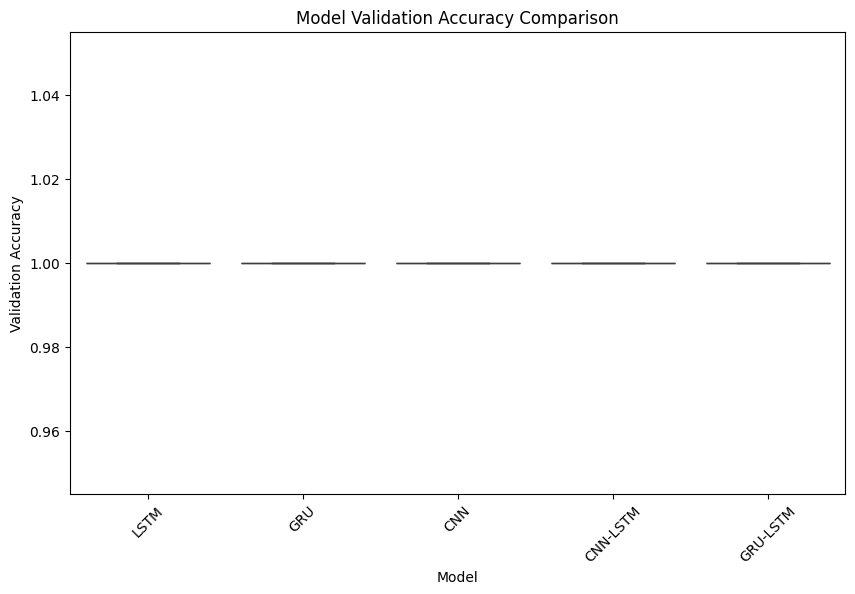

In [6]:
# Collect the final accuracies and losses
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'CNN', 'CNN-LSTM', 'GRU-LSTM'],
    'Accuracy': [
        history_lstm.history['accuracy'][-1],
        history_gru.history['accuracy'][-1],
        history_cnn.history['accuracy'][-1],
        history_cnn_lstm.history['accuracy'][-1],
        history_gru_lstm.history['accuracy'][-1]
    ],
    'Val_Accuracy': [
        history_lstm.history['val_accuracy'][-1],
        history_gru.history['val_accuracy'][-1],
        history_cnn.history['val_accuracy'][-1],
        history_cnn_lstm.history['val_accuracy'][-1],
        history_gru_lstm.history['val_accuracy'][-1]
    ],
    'Loss': [
        history_lstm.history['loss'][-1],
        history_gru.history['loss'][-1],
        history_cnn.history['loss'][-1],
        history_cnn_lstm.history['loss'][-1],
        history_gru_lstm.history['loss'][-1]
    ],
    'Val_Loss': [
        history_lstm.history['val_loss'][-1],
        history_gru.history['val_loss'][-1],
        history_cnn.history['val_loss'][-1],
        history_cnn_lstm.history['val_loss'][-1],
        history_gru_lstm.history['val_loss'][-1]
    ]
})

# Display the results
print("Final Accuracies, Validation Accuracies, Losses, and Validation Losses for Each Model:")
print(results)

# Box Plot with improved clarity
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Val_Accuracy', data=results)
plt.title('Model Validation Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.show()


# F1-Score Calculation and Bar Chart

19/19 [==============================] - 1s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-

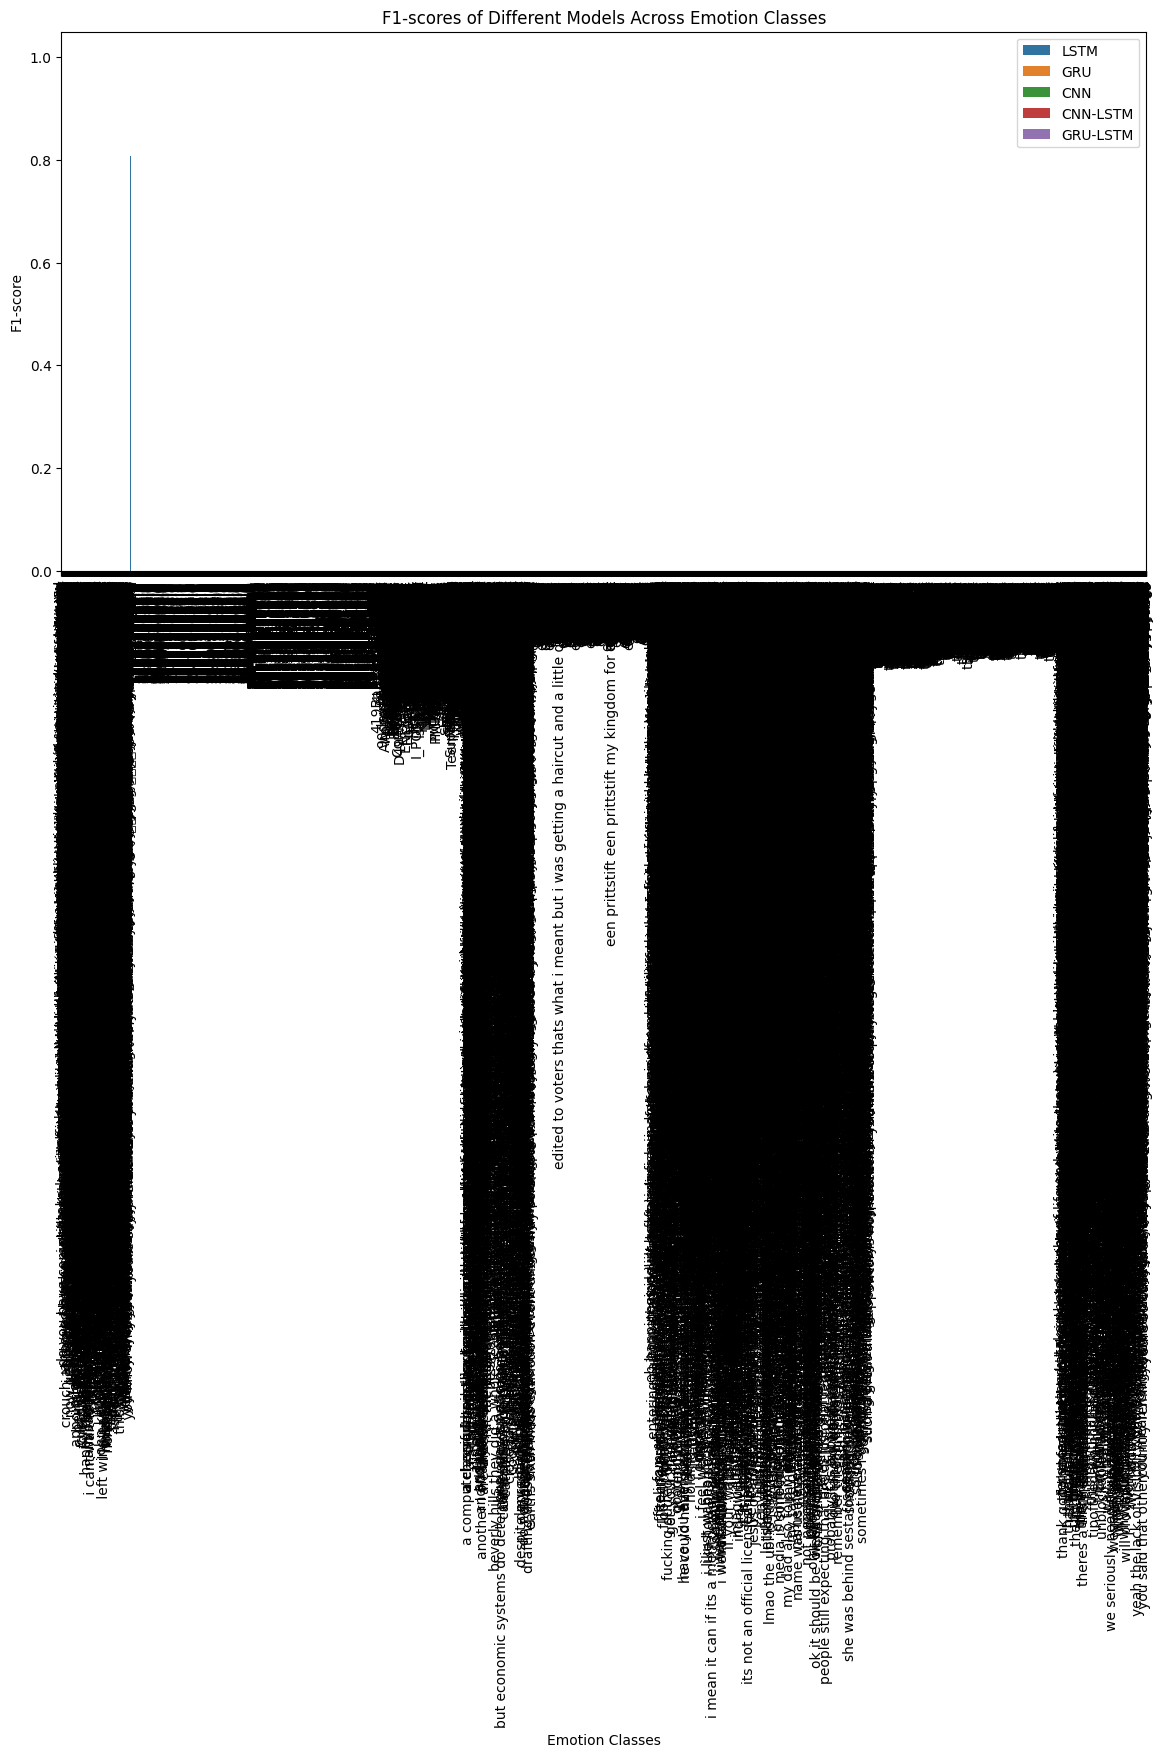

In [7]:
from sklearn.metrics import f1_score
import seaborn as sns

# Make predictions on the validation set
predictions_lstm = lstm_model.predict(val_data)
predictions_gru = gru_model.predict(val_data)
predictions_cnn = cnn_model.predict(val_data)
predictions_cnn_lstm = cnn_lstm_model.predict(val_data)
predictions_gru_lstm = gru_lstm_model.predict(val_data)

# Threshold predictions
threshold = 0.5
predictions_lstm = (predictions_lstm > threshold).astype(int)
predictions_gru = (predictions_gru > threshold).astype(int)
predictions_cnn = (predictions_cnn > threshold).astype(int)
predictions_cnn_lstm = (predictions_cnn_lstm > threshold).astype(int)
predictions_gru_lstm = (predictions_gru_lstm > threshold).astype(int)

# Calculate F1-scores for each class
f1_scores_lstm = f1_score(val_labels, predictions_lstm, average=None)
f1_scores_gru = f1_score(val_labels, predictions_gru, average=None)
f1_scores_cnn = f1_score(val_labels, predictions_cnn, average=None)
f1_scores_cnn_lstm = f1_score(val_labels, predictions_cnn_lstm, average=None)
f1_scores_gru_lstm = f1_score(val_labels, predictions_gru_lstm, average=None)

# Combine F1-scores into a DataFrame
emotion_classes = mlb.classes_
f1_scores_df = pd.DataFrame({
    'Emotion Classes': emotion_classes,
    'LSTM': f1_scores_lstm,
    'GRU': f1_scores_gru,
    'CNN': f1_scores_cnn,
    'CNN-LSTM': f1_scores_cnn_lstm,
    'GRU-LSTM': f1_scores_gru_lstm
})

# Melt the DataFrame for easier plotting with seaborn
f1_scores_melted = pd.melt(f1_scores_df, id_vars='Emotion Classes', var_name='Model', value_name='F1-score')

# Plot the data
plt.figure(figsize=(14, 7))
sns.barplot(x='Emotion Classes', y='F1-score', hue='Model', data=f1_scores_melted)
plt.xticks(rotation=90)
plt.xlabel('Emotion Classes')
plt.ylabel('F1-score')
plt.title('F1-scores of Different Models Across Emotion Classes')
plt.legend(loc='upper right')
plt.show()
